## Load + Setup
Load bad-apple hash information from the json. Also get the base image dimension for the testing image.

In [ ]:
import json
from PIL import Image
import imagehash
from image_similarity import find_closest_hash, check_none_hash_color

# Get bad-apple hash information
with open('hash_indices.json', 'r') as f:
    hash_information = json.load(f)['Hash Information']
hashes = list(hash_information.keys())
hashes.sort()

In [ ]:
def get_image_dimensions(path):
    img = Image.open(path)
    w,h = img.size
    return w,h
in_width, in_height = get_image_dimensions("testing/frames/output_0001.jpg")

# Important for mapping grid
print(in_width, in_height)


640 360


## Process Runthrough
First, project splits image into a grid of 4x3 rectangles. Can see visualization of this process below.

19200


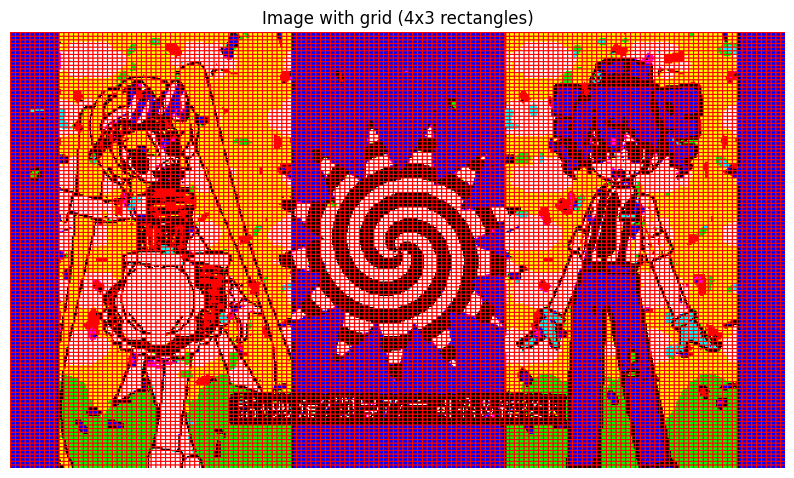

In [ ]:
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np

def get_grid(path, w, h):
    img =  Image.open(path)
    threshold = img.point( lambda p: 255 if p > 127 else 0 )
    
    img = np.array(threshold.convert('RGB'))
    grid_cells = []
    img_height, img_width, _ = img.shape
    # Slice image into grid rectangles
    for y in range(0, img_height, h):
        for x in range(0, img_width, w):
            # Ensure the rectangle stays within image bounds
            cell = img[y:min(y+h, img_height), x:min(x+w, img_width)]
            grid_cells.append(cell)

    return grid_cells

def display_grid_lines(path, w, h):
    img =  Image.open(path)
    threshold = img.point( lambda p: 255 if p > 179 else 0 )
    img = np.array(threshold.convert('RGB'))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_height, img_width, _ = img.shape
    # Slice image into grid rectangles
    # Draw grid lines
    for y in range(0, img_height, h):
        cv2.line(img_rgb, (0, y), (img_width, y), color=(255, 0, 0), thickness=1)
    for x in range(0, img_width, w):
        cv2.line(img_rgb, (x, 0), (x, img_height), color=(255, 0, 0), thickness=1)

    # Display image
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f'Image with grid ({w}x{h} rectangles)')
    plt.show()

TEST_PATH = "testing/frames/output_3797.jpg"
grid_width = 4 # 4 is smallest, 24 is pretty chunky
grid_height = int(grid_width / 4 * 3) # make sure height matches 4 by 3 ratio
grid = get_grid(TEST_PATH, grid_width, grid_height)
print(len(grid))
display_grid_lines(TEST_PATH, grid_width, grid_height)

Then, we map each rectangle in the grid to the closest "bad-apple" image. We do this by comparing their average image hashes.

In [ ]:
def get_frame_mappings(grid):
    grid_frame_indices = []
    for box in grid:
        hash = str(imagehash.average_hash(Image.fromarray(box)))
        closest_hash = find_closest_hash(hash, hashes)
        if closest_hash == "0000000000000000":
            if check_none_hash_color(Image.fromarray(box)): # map none hashes to black or white
                closest_hash = "ffffffffffffffff"
        index = hash_information[closest_hash][0]
        grid_frame_indices.append(index)
    return grid_frame_indices
grid_frame_indices = get_frame_mappings(grid)

Once that finishes, each box on the grid now has a reference to some frame in bad apple. This lower function then assembles that image using the indices.

In [ ]:
def create_image_grid(indices, grid_rows, grid_columns, cell_width, cell_height, background_color=(0,0,0)):
    # Maps badapple images to grid with corresponding badapple indices
    grid_height = cell_height * grid_rows
    grid_width = cell_width * grid_columns
    grid_image = np.full((grid_height, grid_width, 3), background_color, dtype=np.uint8)

    for i, idx in enumerate(indices):
        file_number = '0' * (3 - int(math.log10(idx))) + str(idx)
        path = f"training/frames/output_{file_number}.jpg"

        img = cv2.imread(path)
        img_resized = cv2.resize(img, (cell_width, cell_height))
        row = i // grid_columns
        col = i % grid_columns

        y = row * cell_height
        x = col * cell_width

        grid_image[y:y+cell_height, x:x+cell_width] = img_resized
    
    return grid_image

# Important ratios; if you change it, it might cause error
rows = int(math.ceil(in_height / grid_height)) 
columns = int(math.ceil(in_width / grid_width))
cell_width = 480//16
cell_height = 360//16

output = create_image_grid(grid_frame_indices, rows, columns, cell_width, cell_height)
cv2.imwrite('grid_output.jpg', output)


True

Below brings all the above processes together into one singular process.

In [ ]:
# Combine it all into a single function
def create_bad_apple_image(path):
    # Define grid rectangle size
    grid_width = 8
    grid_height = int(grid_width / 4 * 3)
    
    # Divide the image into a grid
    grid = get_grid(path=path, w=grid_width, h=grid_height)
    # Get the bad apple indices mappings
    grid_frame_indices = get_frame_mappings(grid)

    # Do some quick (and important) ratio math
    rows = int(math.ceil(in_height / grid_height)) 
    columns = int(math.ceil(in_width / grid_width))
    cell_width = 480//16
    cell_height = 360//16

    # assemble the output image using indices
    output = create_image_grid(grid_frame_indices, rows, columns, cell_width, cell_height)
    return output

# output is a cv2 image
output = create_bad_apple_image("testing/frames/output_1259.jpg")
# saves image to current directory
cv2.imwrite('grid_output.jpg', output)

True

# Thing to Run

### Before running checklist
* Define the starting index and total amount of images for whatever you're capturing.
* Make sure in_paths and out_paths match your inputs/outputs

In [ ]:
import shutil

start_idx = 1
TEST_IMAGE_COUNT = 4709 # 4709 frames in mesmerizer
cache = {} # For optimization of duplicate images
for i in range(start_idx,TEST_IMAGE_COUNT+1):
    file_number = '0' * (3 - int(math.log10(i))) + str(i) # adds 0s to number to make it 4 digits long
    in_path = f"testing/frames/output_{file_number}.jpg"
    out_path = f"outputs/frames/output_{file_number}.jpg"
    in_hash = str(imagehash.phash(Image.open(in_path))) # phash is very sensitive to image differences; no false positives

    if in_hash in cache:
        cache_idx = cache[in_hash]
        cache_file_number = '0' * (3 - int(math.log10(cache_idx))) + str(cache_idx)
        cache_path = f"outputs/frames/output_{cache_file_number}.jpg" # cache path should match the same directory as the out path
        print(cache_path, out_path)
        shutil.copy(cache_path, out_path) # copy the cached image in the output path
    else:
        # otherwise, create new bad apple image
        cache[in_hash] = i # add it to the cache. this cache does not empty out its contents.
        output = create_bad_apple_image(in_path)
        cv2.imwrite(out_path, output) # save image


outputs/frames/output_0001.jpg outputs/frames/output_0002.jpg
outputs/frames/output_0001.jpg outputs/frames/output_0003.jpg
outputs/frames/output_0001.jpg outputs/frames/output_0004.jpg
outputs/frames/output_0001.jpg outputs/frames/output_0005.jpg
outputs/frames/output_0001.jpg outputs/frames/output_0006.jpg
outputs/frames/output_0001.jpg outputs/frames/output_0007.jpg
outputs/frames/output_0001.jpg outputs/frames/output_0008.jpg
outputs/frames/output_0001.jpg outputs/frames/output_0009.jpg
outputs/frames/output_0001.jpg outputs/frames/output_0010.jpg
outputs/frames/output_0001.jpg outputs/frames/output_0011.jpg
outputs/frames/output_0001.jpg outputs/frames/output_0012.jpg
outputs/frames/output_0001.jpg outputs/frames/output_0013.jpg
outputs/frames/output_0001.jpg outputs/frames/output_0014.jpg
outputs/frames/output_0001.jpg outputs/frames/output_0015.jpg
outputs/frames/output_0001.jpg outputs/frames/output_0016.jpg
outputs/frames/output_0001.jpg outputs/frames/output_0017.jpg
outputs/